# **Preprocessing**

link : https://www.kaggle.com/carrie1/ecommerce-data/download

In [0]:
import pandas as pd
data = pd.read_csv('data.csv',encoding="ISO-8859-1")

In [107]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Number of null rows by column

In [108]:
data.isnull().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
Country             0
UnitPrice           0
InvoiceDate         0
Quantity            0
StockCode           0
InvoiceNo           0
dtype: int64

Number of customers

In [109]:
len(data)

541909

Removing of null rows in the CustomerID column

In [0]:
data = data.dropna(subset=['CustomerID'])

In [111]:
data.isnull().sum().sort_values(ascending=False)

Country        0
CustomerID     0
UnitPrice      0
InvoiceDate    0
Quantity       0
Description    0
StockCode      0
InvoiceNo      0
dtype: int64

Number of customers after removing

In [112]:
len(data)

406829

Convert date to yyyy-mm-dd format

In [0]:
data['InvoiceDate'] = pd.DatetimeIndex(data['InvoiceDate']).date

In [114]:
data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom


Add a Recency column

In [0]:
last_date  = data['InvoiceDate'].max()

In [0]:
data['Recency'] = data['InvoiceDate'].apply(lambda data: (last_date - data).days)


In [117]:
data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,373
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,373


Keep the date of the last order

In [118]:
last_order = data.groupby(by=['CustomerID'], as_index=False)['Recency'].min()
last_order.head()

,CustomerID,Recency
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


Add the average number or distinct products by customer

In [119]:
distinct_product = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['StockCode'].count()
distinct_product = distinct_product.groupby(by=['CustomerID'], as_index=False)['StockCode'].mean()
distinct_product = distinct_product.rename(columns = {'StockCode':'avg_distinct_product'})
distinct_product.head()

,CustomerID,avg_distinct_product
0,12346.0,1.00
1,12347.0,26.00
2,12348.0,7.75
3,12349.0,73.00
4,12350.0,17.00


Add the average basket

In [120]:
basket = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['Quantity'].sum()
basket = basket.groupby(by=['CustomerID'], as_index=False)['Quantity'].mean()
basket = basket.rename(columns = {'Quantity':'avg_basket'})
basket.head()

,CustomerID,avg_basket
0,12346.0,0.000000
1,12347.0,351.142857
2,12348.0,585.250000
3,12349.0,631.000000
4,12350.0,197.000000


Checking the size of tables is the same 

In [121]:
len(last_order) == len(basket) == len(distinct_product)

True

We have to join the tables to get a final table.

In first we do that to add the country for the last order.

In [122]:
customer = data.groupby(by=['CustomerID', 'Country'], as_index=False)['Recency'].min()
data2 = last_order.merge(customer, on = ['CustomerID','Recency'], how = 'inner')
data2.head()

,CustomerID,Recency,Country
0,12346.0,325,United Kingdom
1,12347.0,2,Iceland
2,12348.0,75,Finland
3,12349.0,18,Italy
4,12350.0,310,Norway


Join with the others tables

In [123]:
data2 = data2.merge(basket, on = ['CustomerID'], how = 'inner')
data2 = data2.merge(distinct_product, on = ['CustomerID'], how = 'inner')

data2.head()

,CustomerID,Recency,Country,avg_basket,avg_distinct_product
0,12346.0,325,United Kingdom,0.000000,1.00
1,12347.0,2,Iceland,351.142857,26.00
2,12348.0,75,Finland,585.250000,7.75
3,12349.0,18,Italy,631.000000,73.00
4,12350.0,310,Norway,197.000000,17.00


The new table kept the same size then is good.

In [124]:
len(data2) == len(last_order) == len(basket) == len(distinct_product)

True

# **K-Means**

Encoding of the Country column

In [125]:
from sklearn.preprocessing import LabelEncoder

country_encoded = LabelEncoder().fit_transform(data2[['Country']])

data_enc = data2.copy()
data_enc['Country'] = country_encoded

data_enc.head()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,CustomerID,Recency,Country,avg_basket,avg_distinct_product
0,12346.0,325,35,0.000000,1.00
1,12347.0,2,16,351.142857,26.00
2,12348.0,75,12,585.250000,7.75
3,12349.0,18,18,631.000000,73.00
4,12350.0,310,24,197.000000,17.00


Standardization

In [0]:
from sklearn.preprocessing import StandardScaler

X = data_enc.drop('CustomerID', axis=1)
scaler = StandardScaler()
scaler.fit(X)

X = scaler.transform(X)

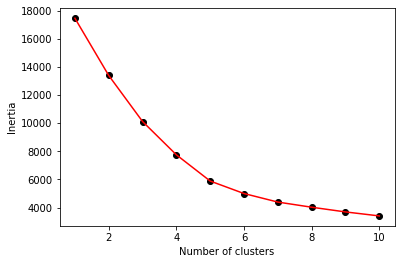

In [127]:
from sklearn.cluster import KMeans
import numpy as np

inertia = []

for i in range(1, 11):
  model = KMeans(n_clusters=i, random_state=0)
  model.fit(X)
  inertia.append(model.inertia_)

import matplotlib.pyplot as plt

plt.plot([i for i in range(1,11)], inertia, 'o', color = 'black')
plt.plot([i for i in range(1,11)], inertia, '-', color = 'red')

plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# **Clusters analysis**

For 4 clusters

In [128]:
model = KMeans(n_clusters=6, random_state=0)
model.fit(X)

data2['Cluster']=model.labels_

for i in range(4) :
  print ("Cluster " + str(i+1))
  print(data2[data2['Cluster']== i].drop(['CustomerID', 'Country'], axis=1).describe())
  print()

Cluster 1
           Recency   avg_basket  avg_distinct_product  Cluster
count  2570.000000  2570.000000           2570.000000   2570.0
mean     40.970817   163.534401             14.811566      0.0
std      36.503789   119.202596              8.545374      0.0
min       0.000000   -94.500000              1.000000      0.0
25%      10.000000    81.041667              8.000000      0.0
50%      30.000000   135.000000             13.800000      0.0
75%      64.000000   215.475000             20.787500      0.0
max     156.000000   892.750000             37.750000      0.0

Cluster 2
          Recency   avg_basket  avg_distinct_product  Cluster
count  298.000000   298.000000            298.000000    298.0
mean    93.661074   228.017835             19.129589      1.0
std    108.250314   183.210336             13.679817      0.0
min      0.000000   -56.000000              1.000000      1.0
25%     14.000000   100.350000             10.000000      1.0
50%     43.000000   175.916667          

Customers by country

In [129]:
for i in range(4) :
  print ("Cluster " + str(i+1))
  print(data2[data2['Cluster']== i]['Country'].value_counts())
  print()

Cluster 1
United Kingdom          2504
Spain                     19
Switzerland               11
Portugal                   9
Norway                     6
Poland                     6
Sweden                     5
Netherlands                4
Unspecified                2
USA                        2
United Arab Emirates       1
Singapore                  1
Name: Country, dtype: int64

Cluster 2
Germany               93
France                87
Belgium               23
Italy                 13
Finland               12
Denmark                9
Austria                9
Channel Islands        9
Australia              8
Cyprus                 6
Japan                  5
Canada                 4
Greece                 4
EIRE                   3
Israel                 3
Bahrain                2
Malta                  2
European Community     1
Brazil                 1
Lebanon                1
Czech Republic         1
Iceland                1
Netherlands            1
Name: Country, dtype: int64
